In [32]:
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt

In [33]:
from scipy.stats import norm
import datetime
from random import randint
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [34]:
# Function for Ruptures implementation

def detect_changes_plot_graph(time_series):
    # Convert time series to a numpy array
    signal = time_series.values

    # Perform change point detection using the Pelt algorithm
    algo = rpt.Pelt(model="rbf", min_size=1, jump=10).fit(signal)
    result = algo.predict(pen=2)

    # remove location if equal to len(signal)
    change_points = [i for i in result if i < len(signal)]
    # print(algo.predict(pen = 1))
    
    # Plot the time series 
    fig, ax = plt.subplots(figsize=(18, 9))
    ax.plot(time_series, lw=0.75, label="Data", color="blue")

    # Plot the abrupt changes
    for i in change_points:
        ax.axvline(time_series.index[i], color="red", linestyle="dashed", lw=2)

    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.set_title('Time Series with Abrupt Changes')
    ax.legend()
    ax.grid(True)
    ax.grid(alpha=0.75, linestyle="dotted", lw=2)

    # Show the plot
    plt.show()

    # Return the list of change point locations
    return change_points


In [35]:
class CusumDetector:
    
    def __init__(self, t_warmup = 30, p_limit= 0.01):
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        self._reset()
        
    def predict_next(self, y):
        self._update_data(y)
        
        if self.current_t == self._t_warmup:
            self._init_params()
            
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            
            if is_changepoint:
                self._reset()
                
            return (1-prob), is_changepoint
        
        else:
            return 0, False
        
    def _reset(self):
        self.current_t = 0
        self.current_obs = []
        self.current_mean = None
        self.current_std = None
        
    def _update_data(self, y):
        self.current_t += 1
        self.current_obs.append(y)

    def _init_params(self):
        self.obs = pd.Series(self.current_obs)
        f = Fitter(self.obs, distributions=["norm"])
        f.fit()
        self.current_mean = f.fitted_param["norm"][0]
        self.current_std = f.fitted_param["norm"][1]
        
    def _check_for_changepoint(self):
        standardized_sum = (np.sum(self.current_obs) - (self.current_t * self.current_mean)) / (self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum))
        
        return prob, prob < self._p_limit
    
    def _get_prob(self, y):
        p = norm.cdf(np.abs(y))  # 0.5 * (1 + np.math.erf(np.abs(y) / np.sqrt(2)))
        prob = 2 * (1 - p)
        
        return prob
    
    def extract_prob_checkpoint_sep(self, y):
        
        self._reset()
        ret_val = [test.predict_next(y[i]) for i in range(len(y))]
        cps = np.where(list(map(lambda x: x[1], ret_val)))[0]
        probs = np.array(list(map(lambda x: x[0], ret_val)))
        
        return probs, cps
    
    def extract_prob_checkpoint(self, y):
        
        self._reset()
        ret_val = [test.predict_next(y[i]) for i in range(len(y))]
        
        return ret_val
    
    def plot_contour_checkpoint(self, y):
        
        self._reset()
        outs = [test.predict_next(y[i]) for i in range(len(y))]
        
        cps = np.where(list(map(lambda x: x[1], outs)))[0]
        probs = np.array(list(map(lambda x: x[0], outs)))
        
        print(cps)
        
        # Plot results
        X, Y = np.meshgrid(np.arange(len(y)), np.linspace(-11, 11))
        Z = probs[X]

        plt.figure(figsize=(18, 9))
        plt.contourf(X, Y, Z, alpha=0.3, cmap="Reds")
        plt.plot(np.arange(len(y)), y, lw=0.75, label="Data", color="blue")

        # Plot detected changepoints
        [plt.axvline(cp, color="red", linestyle="dashed", lw=2) for cp in cps]

        plt.grid(alpha=0.75, linestyle="dotted", lw=2)
        plt.legend()
        plt.title("CUSUM Results")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.show()
    
    def plot_checkpoint(self, y):
        
        self._reset()
        outs = [test.predict_next(y[i]) for i in range(len(y))]
        
        cps = np.where(list(map(lambda x: x[1], outs)))[0]
        
        print(cps)
        
        plt.figure(figsize=(18, 9))
        plt.plot(np.arange(len(y)), y, lw=0.75, label="Data", color="blue")

        # Plot detected changepoints
        [plt.axvline(cp, color="red", linestyle="dashed", lw=2) for cp in cps]

        plt.grid(alpha=0.75, linestyle="dotted", lw=2)
        plt.legend()
        plt.title("CUSUM Results")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.show()

In [36]:
# Initialize CUSUM detector
test = CusumDetector()

In [37]:
file_path = r'C:\Users\General\Desktop\CAPSTONE\Datasets'
# C:\Users\General\Desktop\MSc Data Science\CAPSTONE\Datasets

# Read the CSV file into a pandas DataFrame
a_1 = pd.read_csv(file_path + '\\timeseries1.csv')
a_2 = pd.read_csv(file_path + '\\timeseries2.csv')
a_3 = pd.read_csv(file_path + '\\timeseries3.csv')

In [38]:
y_1 = a_1['value']
y_2 = a_2['value']
y_3 = a_3['value']

## Dataset 1

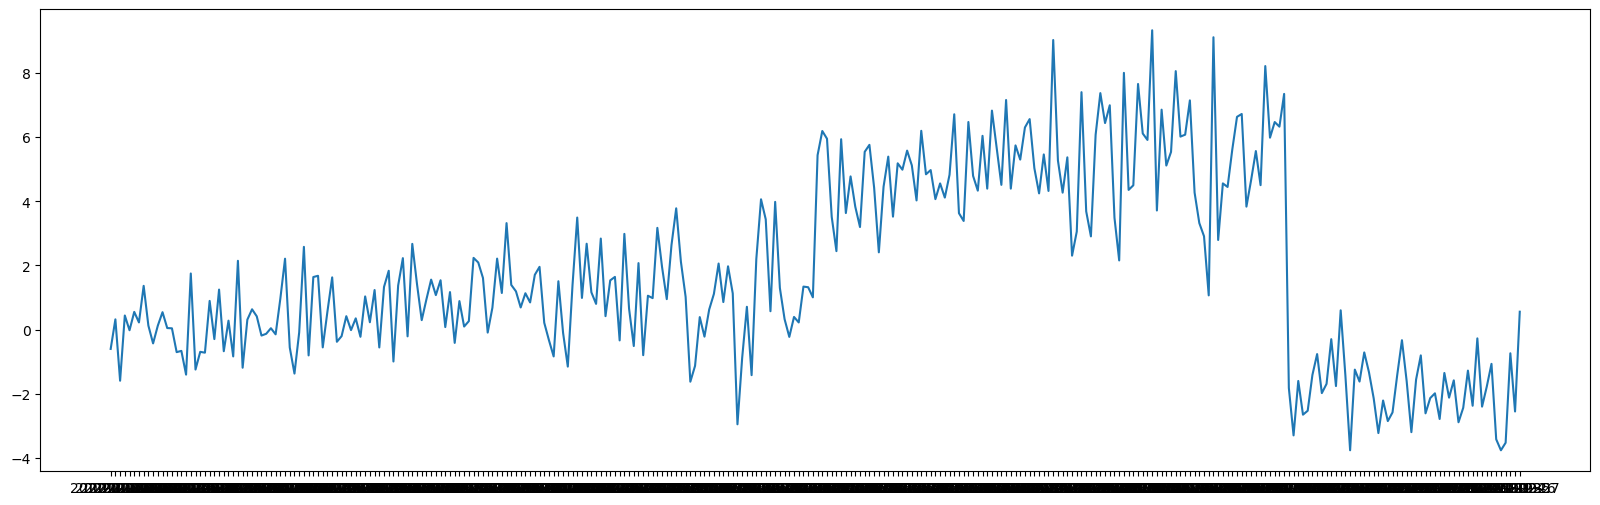

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(a_1['date'], a_1['value'])
plt.show()

### Ruptures Implementation

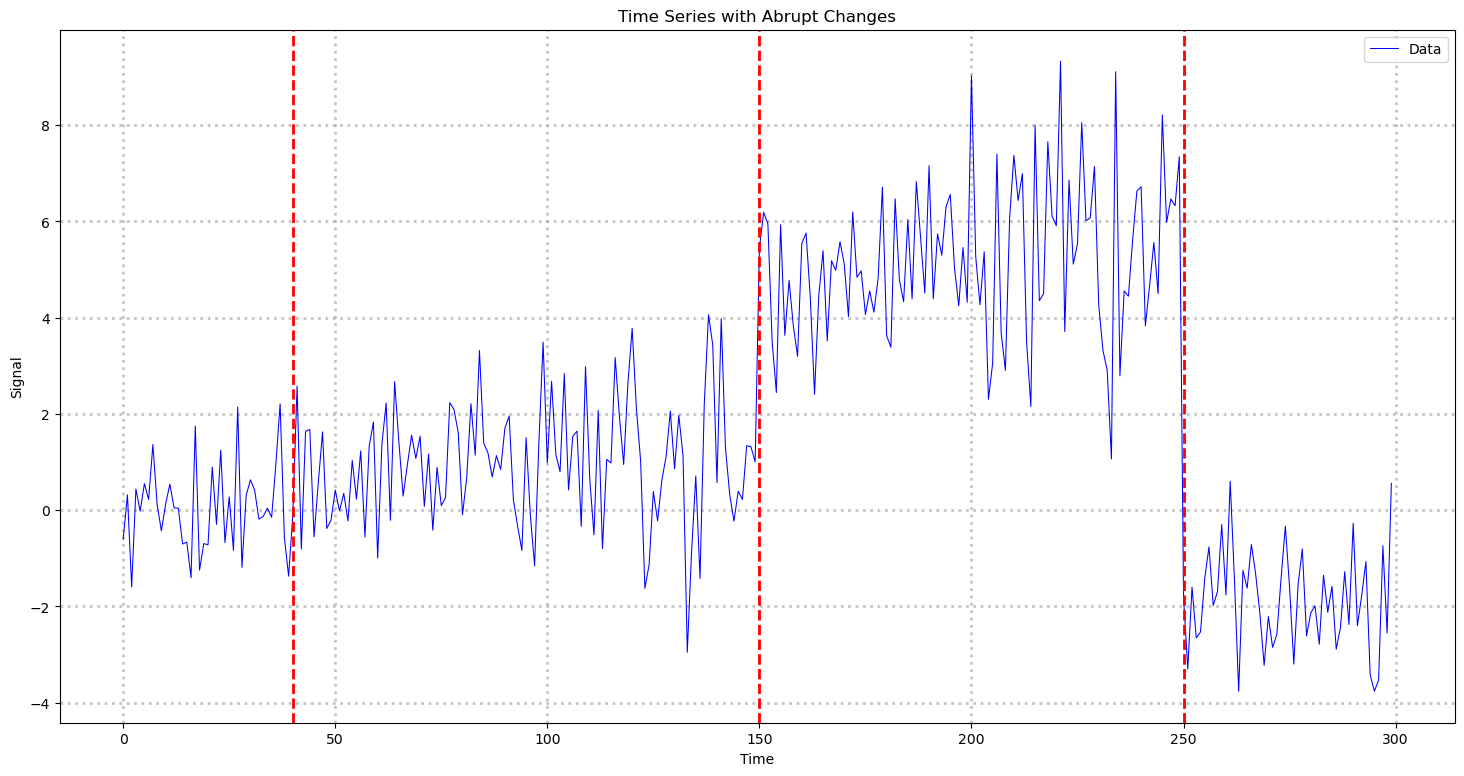

[40, 150, 250]

In [47]:
# Detect abrupt changes
detect_changes_plot_graph(y_1)

### CUSUM Implementation

2024-05-13 18:43:24.858 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-05-13 18:43:24.909 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-05-13 18:43:24.960 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-05-13 18:43:25.001 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-05-13 18:43:25.045 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


[ 64 154 212 255]


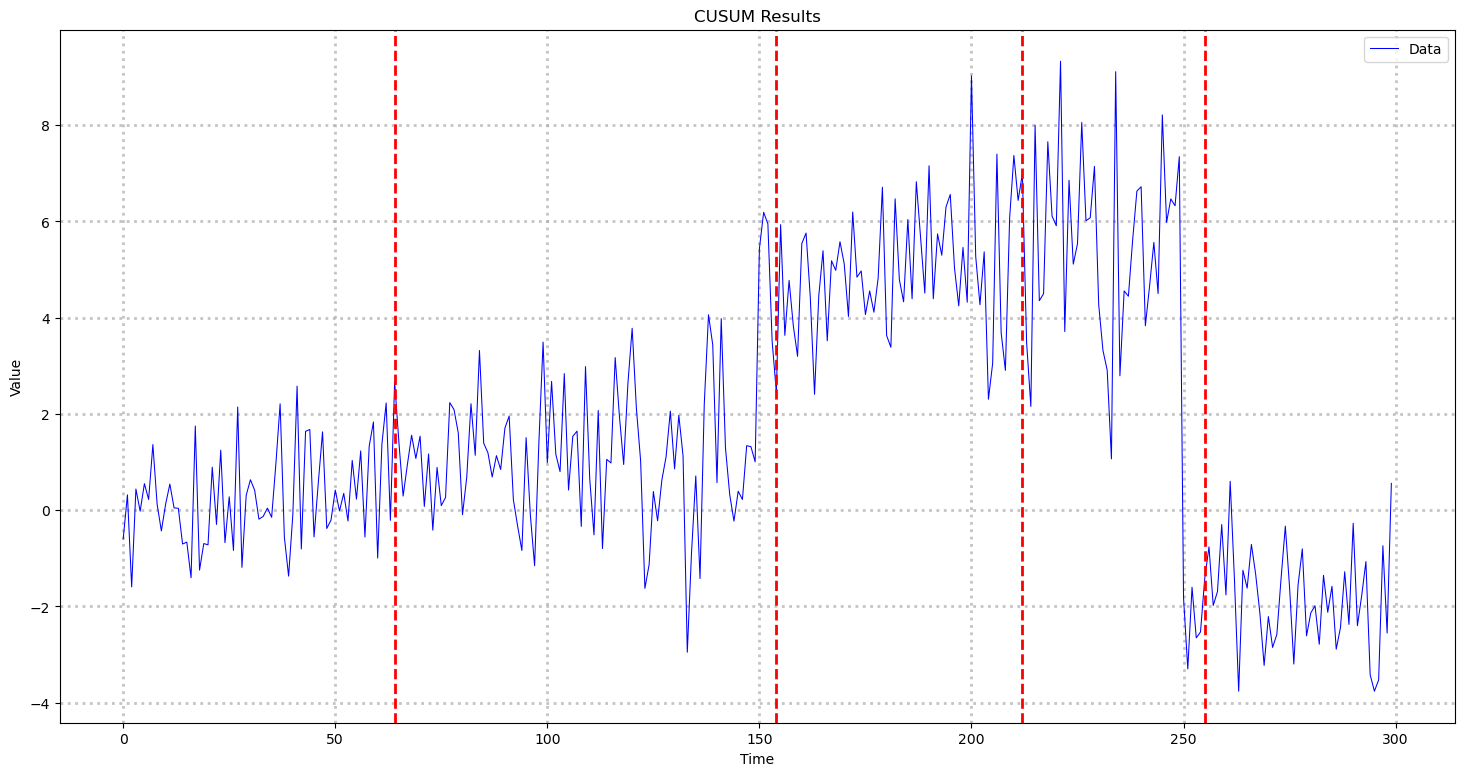

In [39]:
test.plot_checkpoint(y_1)

## Dataset 2

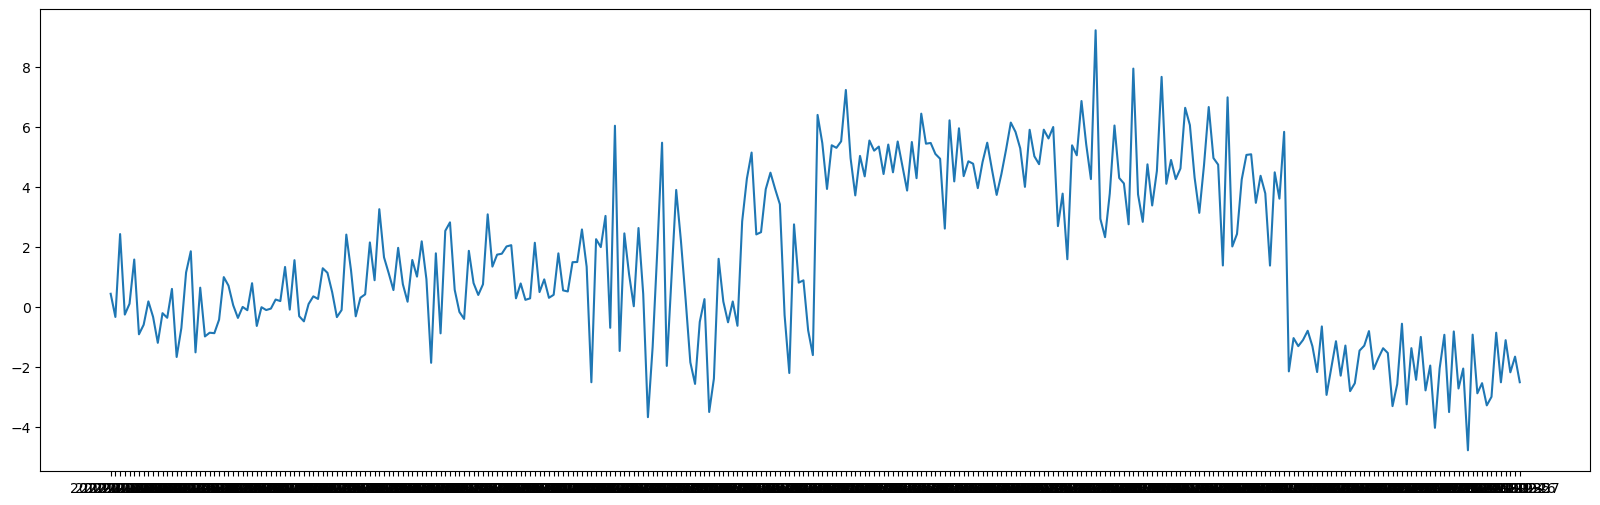

In [40]:
plt.figure(figsize=(20, 6))
plt.plot(a_2['date'], a_2['value'])
plt.show()

### Ruptures Implementation

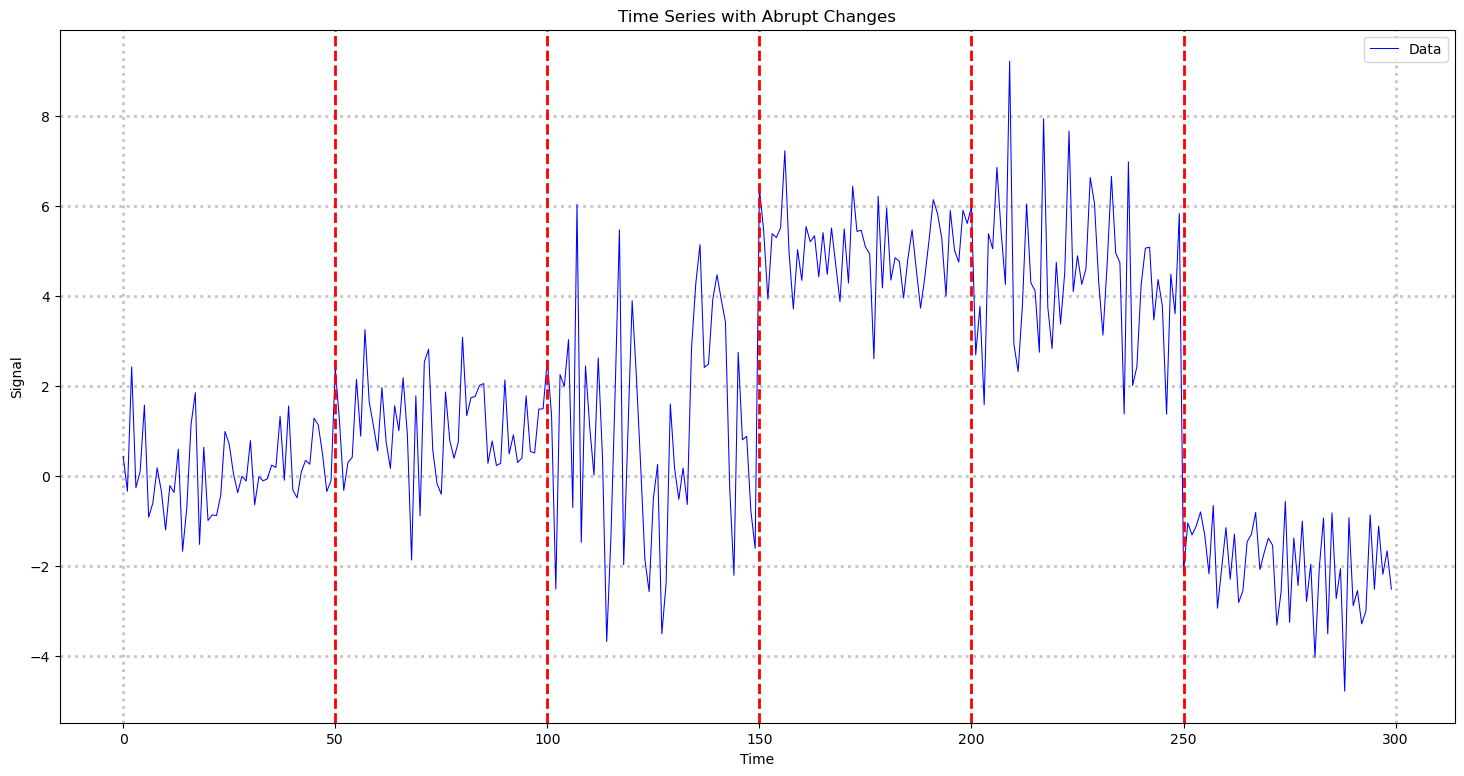

In [41]:
# Detect abrupt changes
changes_2 = detect_changes_plot_graph(y_2)

### CUSUM Implementation

2024-05-13 18:43:28.232 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=16.368181)
2024-05-13 18:43:28.279 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=11.981057)
2024-05-13 18:43:28.333 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=18.893876)
2024-05-13 18:43:28.381 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=43.929834)


[ 59 156 250]


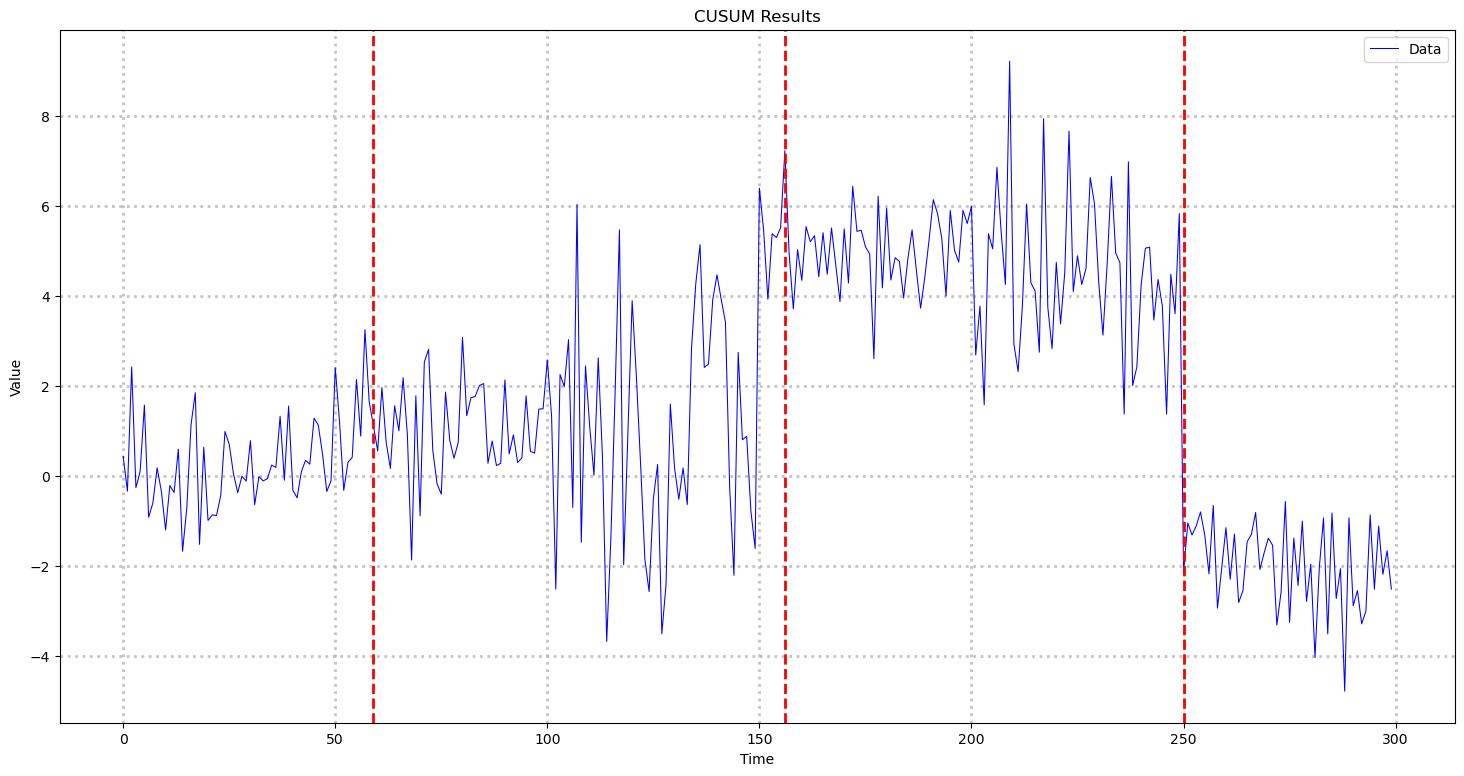

In [42]:
test.plot_checkpoint(y_2)

## Dataset 3

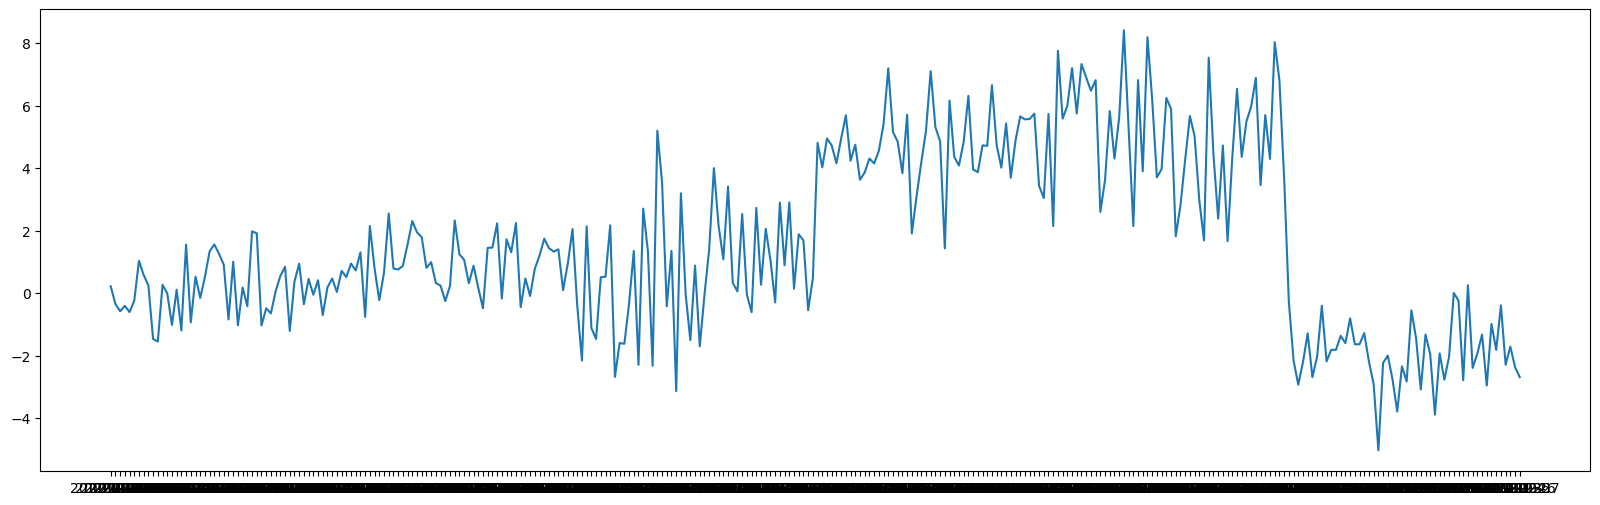

In [43]:
plt.figure(figsize=(20, 6))
plt.plot(a_3['date'], a_3['value'])
plt.show()

### Ruptures Implementation

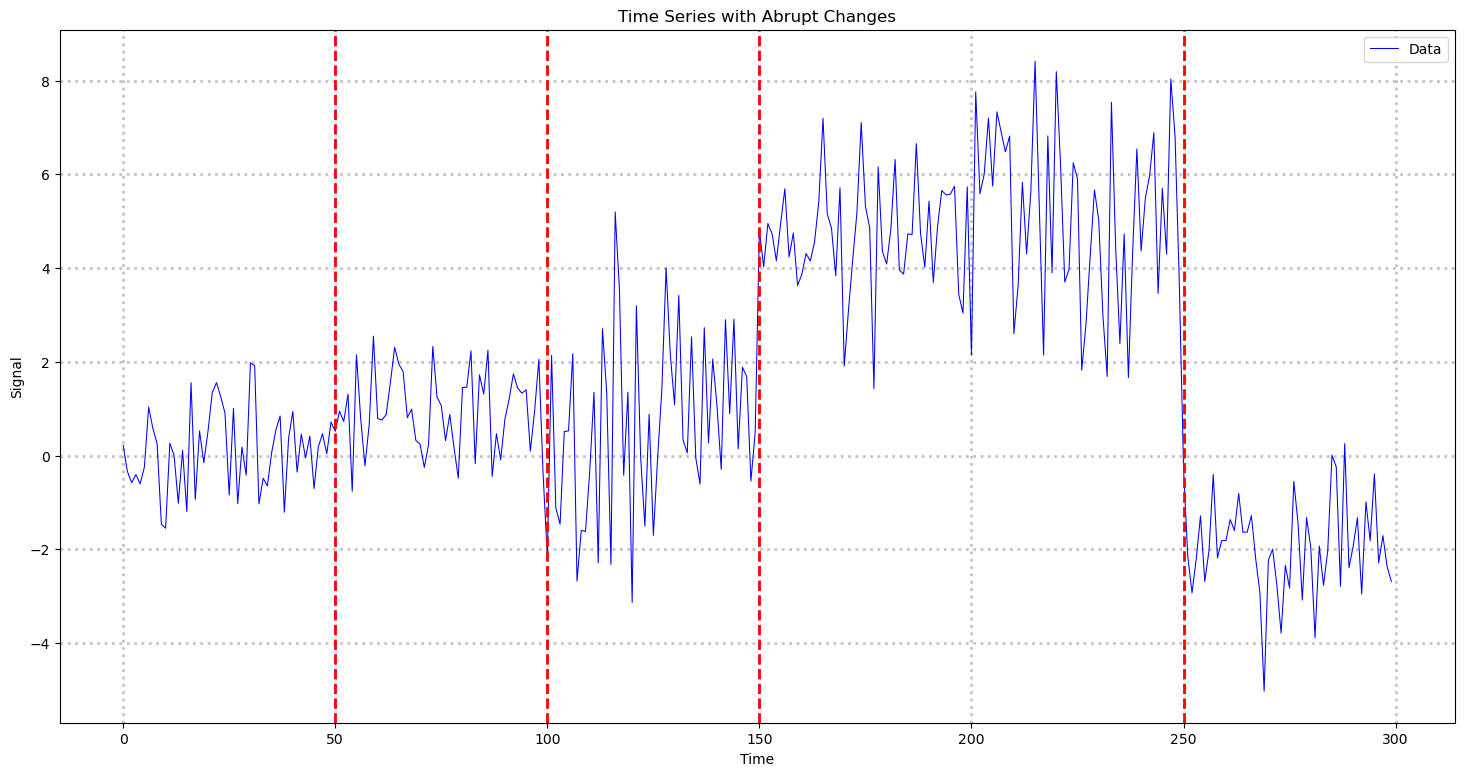

In [44]:
# Detect abrupt changes
changes_3 = detect_changes_plot_graph(y_3)

### CUSUM Implementation

2024-05-13 18:43:32.080 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=31.83117)
2024-05-13 18:43:32.118 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=39.346501)
2024-05-13 18:43:32.162 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=4.754133)
2024-05-13 18:43:32.206 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=9.902312)
2024-05-13 18:43:32.248 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=14.11546)


[ 64 109 158 258]


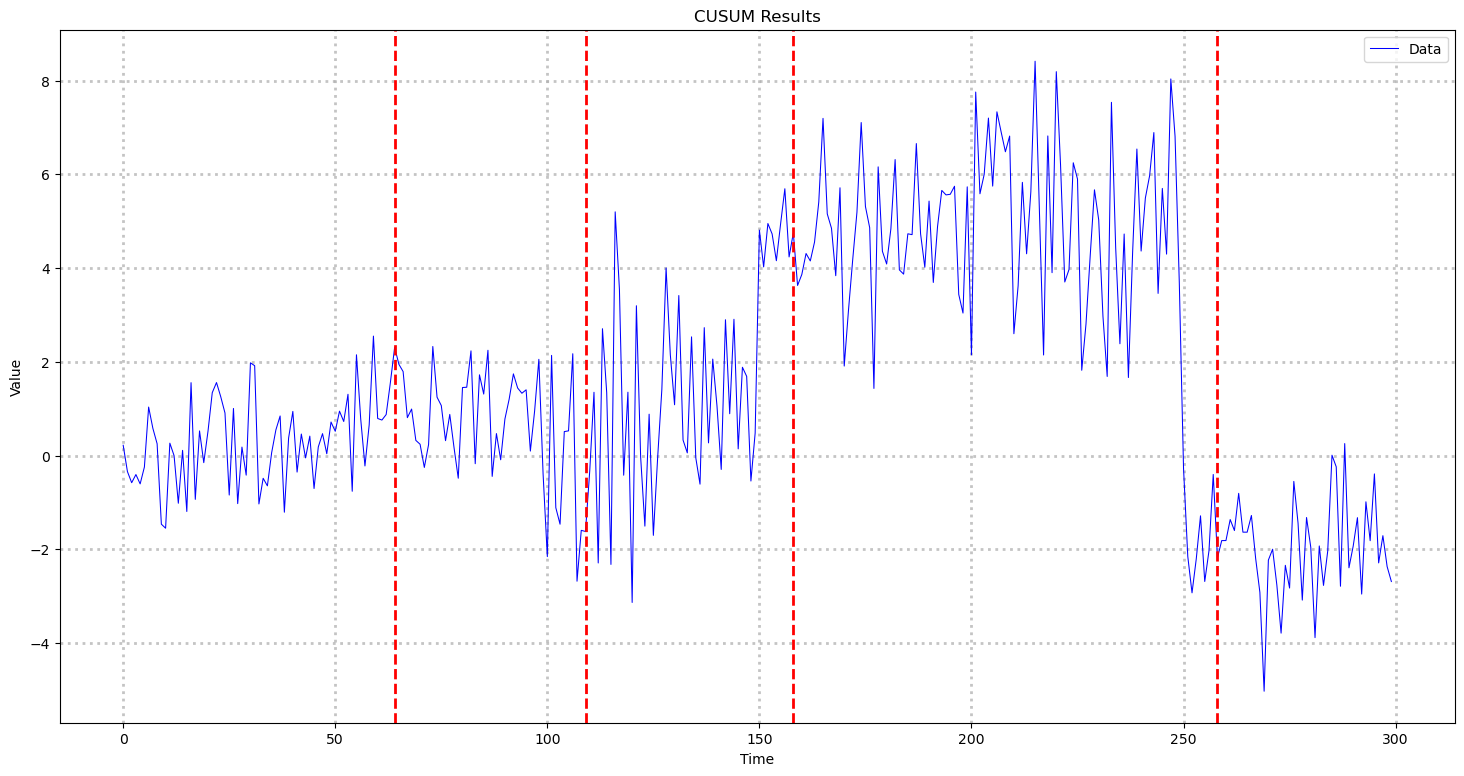

In [45]:
test.plot_checkpoint(y_3)